## Classification

In this lecture, I will bring together various techniques for feature engineering that we have covered in this course to tackle a classification problem. This would give you an idea of the end-to-end pipeline to build machine learning algorithms for classification. 

I will:
- build a gradient boosted tree
- use feature-engine for the feature engineering steps
- set up an entire engineering and prediction pipeline using a Scikit-learn Pipeline

============================================================================

## In this demo:

We will use the titanic dataset, please refer to lecture **Datasets** in Section 1 of the course for instructions on how to download and prepare this dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# for feature engineering
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

In [3]:
# load dataset

cols = [
    'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
    'embarked', 'survived'
]

data = pd.read_csv('../titanic.csv', usecols=cols)

data.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


### Types of variables (section 2)

Let's find out what types of variables there are in this dataset

In [4]:
# let's inspect the type of variables in pandas

data.dtypes

survived      int64
pclass        int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
cabin        object
embarked     object
dtype: object

There are categorical and numerical variables.

In [6]:
# let's inspect the variable values

for var in data.columns:
    print(var, data[var].nunique(), '\n')    
    print(var, data[var].unique()[0:20], '\n')

survived 2 

survived [0 1] 

pclass 3 

pclass [3 1 2] 

sex 2 

sex ['male' 'female'] 

age 88 

age [22. 38. 26. 35. nan 54.  2. 27. 14.  4. 58. 20. 39. 55. 31. 34. 15. 28.
  8. 19.] 

sibsp 7 

sibsp [1 0 3 4 2 5 8] 

parch 7 

parch [0 1 2 5 3 4 6] 

fare 248 

fare [ 7.25   71.2833  7.925  53.1     8.05    8.4583 51.8625 21.075  11.1333
 30.0708 16.7    26.55   31.275   7.8542 16.     29.125  13.     18.
  7.225  26.    ] 

cabin 147 

cabin [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12'] 

embarked 3 

embarked ['S' 'C' 'Q' nan] 



There continuous and discrete variables and also mixed variables.

In [7]:
# make list of variables  types

# numerical: discrete vs continuous
discrete = [var for var in data.columns if data[var].dtype!='O' and var!='survived' and data[var].nunique()<10]
continuous = [var for var in data.columns if data[var].dtype!='O' and var!='survived' and var not in discrete]

# mixed
mixed = ['cabin']

# categorical
categorical = [var for var in data.columns if data[var].dtype=='O' and var not in mixed]

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))
print('There are {} mixed variables'.format(len(mixed)))

There are 3 discrete variables
There are 2 continuous variables
There are 2 categorical variables
There are 1 mixed variables


In [8]:
discrete

['pclass', 'sibsp', 'parch']

In [9]:
continuous

['age', 'fare']

In [10]:
categorical

['sex', 'embarked']

In [11]:
mixed

['cabin']

### Variable characteristics (section 3)

In [12]:
# missing data

data.isnull().mean()

survived    0.000000
pclass      0.000000
sex         0.000000
age         0.198653
sibsp       0.000000
parch       0.000000
fare        0.000000
cabin       0.771044
embarked    0.002245
dtype: float64

There is missing data in our variables.

In [13]:
# cardinality (number of different categories)

data[categorical+mixed].nunique()

sex           2
embarked      3
cabin       147
dtype: int64

Some variables are highly cardinal.

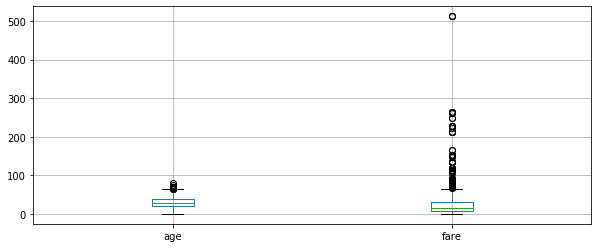

In [14]:
# outliers

data[continuous].boxplot(figsize=(10,4))

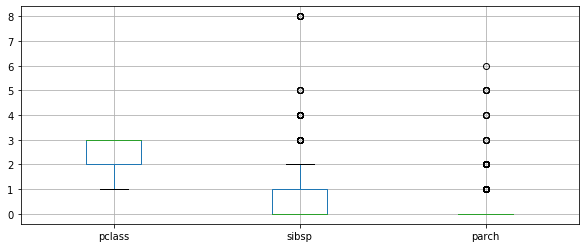

In [15]:
# outliers in discrete
data[discrete].boxplot(figsize=(10,4))

Some variables show outliers or unusual values.

In [16]:
# values bigger than 3 are rare for parch

data['parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: parch, dtype: int64

In [17]:
# feature magnitude

data.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Features are in different ranges or scales. But this is not relevant for gradient boosted trees. 

### Engineering mixed type of variables (section 11)

Extract numerical and categorical parts of variables.

In [18]:
# Cabin
data['cabin_num'] = data['cabin'].str.extract('(\d+)') # captures numerical part
data['cabin_num'] = data['cabin_num'].astype('float')
data['cabin_cat'] = data['cabin'].str[0] # captures the first letter

# show dataframe
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,cabin_num,cabin_cat
0,0,3,male,22.0,1,0,7.2500,NaN,S,NaN,NaN
1,1,1,female,38.0,1,0,71.2833,C85,C,85.0,C
2,1,3,female,26.0,0,0,7.9250,NaN,S,NaN,NaN
3,1,1,female,35.0,1,0,53.1000,C123,S,123.0,C
4,0,3,male,35.0,0,0,8.0500,NaN,S,NaN,NaN


Now that we extracted the numerical and categorical part, we can discard the mixed variable Cabin.

In [17]:
# drop original mixed

data.drop(['cabin'], axis=1, inplace=True)

In [18]:
# separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1178, 9), (131, 9))

### Missing data imputation (Section 4)

In [19]:
# numerical

X_train.select_dtypes(exclude='O').isnull().mean()

pclass       0.000000
age          0.198642
sibsp        0.000000
parch        0.000000
fare         0.000849
cabin_num    0.782683
dtype: float64

In [20]:
# categorical

X_train.select_dtypes(include='O').isnull().mean()

sex          0.000000
embarked     0.001698
cabin_cat    0.771647
dtype: float64

Imputation methods I will perform:

- Numerical: arbitrary value imputation
- Categorical: add missing label imputation

Because I will build a Gradient Boosted tree, I am not particularly worried about disturbing linearity or distributions of variables.

### Categorical encoding and rare labels (Section 6)

In [21]:
# check cardinality again

X_train[['cabin_cat', 'sex', 'embarked']].nunique()

cabin_cat    8
sex          2
embarked     3
dtype: int64

Now that I extracted the numerical and categorical part from cabin, its cardinality is not so high.

In [22]:
# check variable frequency

var = 'cabin_cat'
(X_train[var].value_counts() / len(X_train)).sort_values()

T    0.000849
G    0.003396
A    0.016978
F    0.016978
E    0.033107
D    0.033956
B    0.049236
C    0.073854
Name: cabin_cat, dtype: float64

Categories T and G appear only in few observations, so I will replace them into rare.

### Discretisation or Variable transformation (Sections 7 and 8)

Let's inspect the variable distributions.

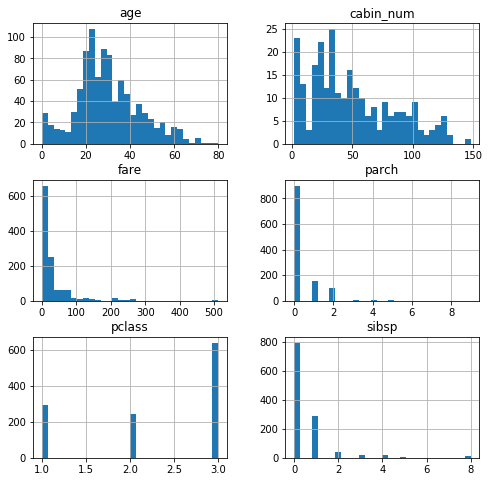

In [23]:
# numerical

X_train.select_dtypes(exclude='O').hist(bins=30, figsize=(8,8))
plt.show()

For decision trees, the variable distribution is not so important, so in principle, we don't need to change it. Also decision trees are robust to outliers.

### Putting it all together

In [24]:
titanic_pipe = Pipeline([

    # missing data imputation - section 4
    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['age', 'fare', 'cabin_num'])),
    ('imputer_cat',
     mdi.CategoricalVariableImputer(variables=['embarked', 'cabin_cat'])),

    # categorical encoding - section 6
    ('encoder_rare_label',
     ce.RareLabelCategoricalEncoder(tol=0.01,
                                    n_categories=6,
                                    variables=['cabin_cat'])),
    ('categorical_encoder',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=['cabin_cat', 'sex', 'embarked'])),

    # Gradient Boosted machine
    ('gbm', GradientBoostingClassifier(random_state=0))
])

In [25]:
# let's fit the pipeline and make predictions
titanic_pipe.fit(X_train, y_train)

X_train_preds = titanic_pipe.predict_proba(X_train)[:,1]
X_test_preds = titanic_pipe.predict_proba(X_test)[:,1]

In [26]:
# a peek into the prediction values
X_train_preds

array([0.27876558, 0.08146821, 0.46816053, ..., 0.70745459, 0.90809699,
       0.4980871 ])

In [27]:
print('Train set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

print('Test set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Train set
GBM roc-auc: 0.9269576293912577
Test set
GBM roc-auc: 0.8396084337349397


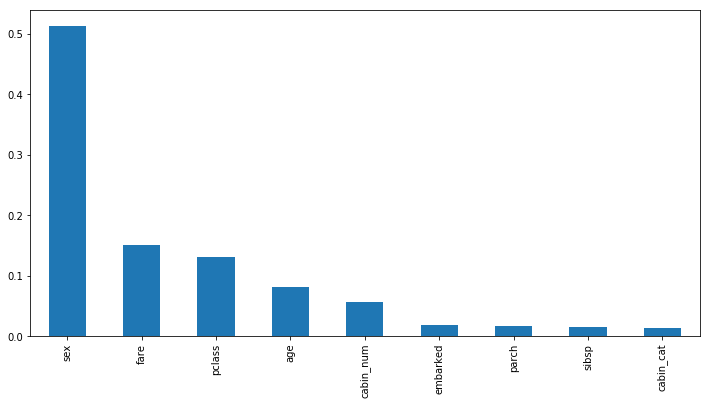

In [28]:
# let's explore the importance of the features

importance = pd.Series(titanic_pipe.named_steps['gbm'].feature_importances_)
importance.index = data.drop('survived', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))